In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import pandas as pd
from timeit import timeit
import cv2
import matplotlib.pyplot as plt
from algorithm import create_panoramic_view

# **Panoramic creator experimentation** - Computer Vision and 3D Reconstruction

**Author:** Cristian Comellas Fluxá

---

## Introduction

In this notebook a set of tests related to the algorithm for creating panoramas from images is performed. Variations in the match ratio and the keypoint detector will be tested.

## Experiments

In this section experiments will be carried out to test the performance of the panoramic creation algorithm.

Before starting, a function is created that will be used as an auxiliary function to load the images used in the experiments.

In [3]:
def read_images(name, extension='jpg', n=3):
    images = []
    for i in range(1, n+1):
        img = cv2.imread(f'./images/{name}{i}.{extension}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

### Matching ratio experiments

In this section, experiments will be carried out to test the performance of the panoramic creation algorithm with different matching ratios. 

The matching ratio is the ratio between the distance of the first and second best matches of each keypoint. The lower the ratio, the more similar the first and second best matches are, and therefore the more difficult it is to find the correct match. When we decrease the matching ratio, we reduce the number of matches we consider correct, and therefore the number of matches we use to calculate the homography matrix. This aids to discard bad matches improving the quality of the final panorama, but it also makes it more difficult to find enough correct matches.

We are going to test the algorithm with matching ratios of 0.5, 0.7, and 0.9.

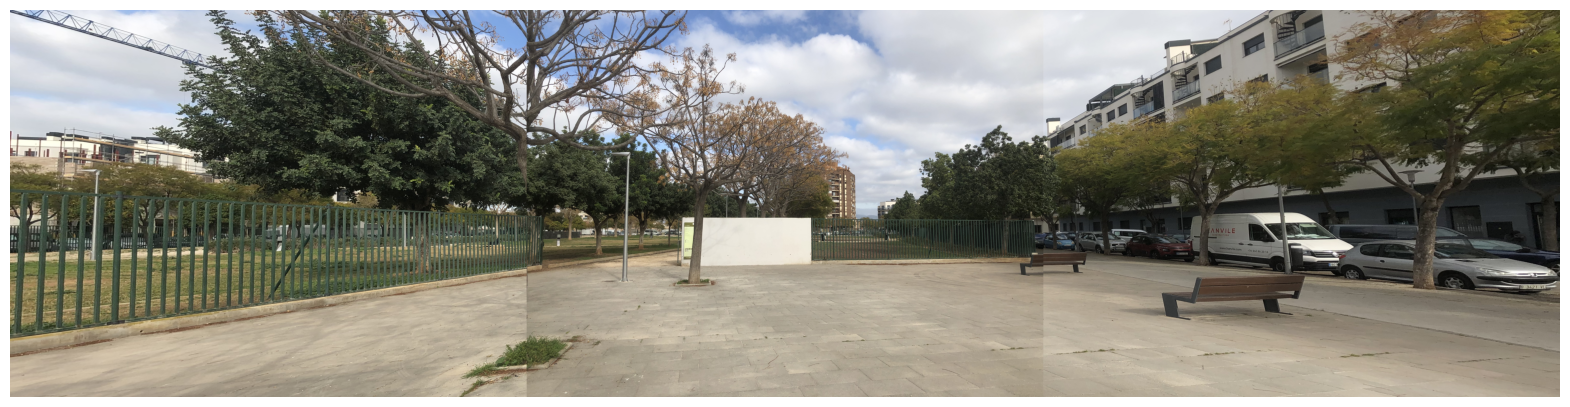

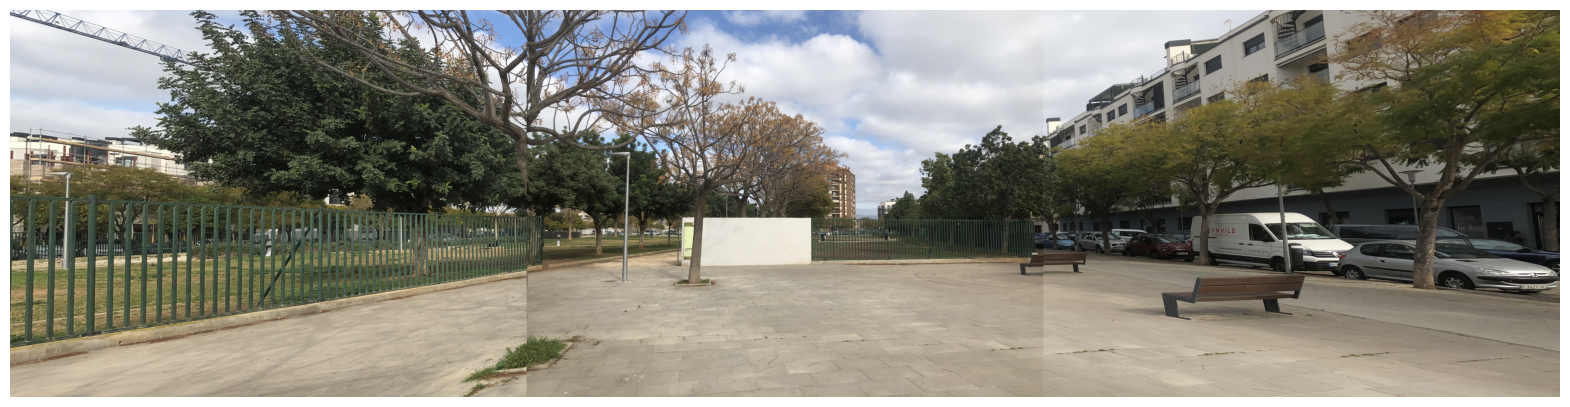

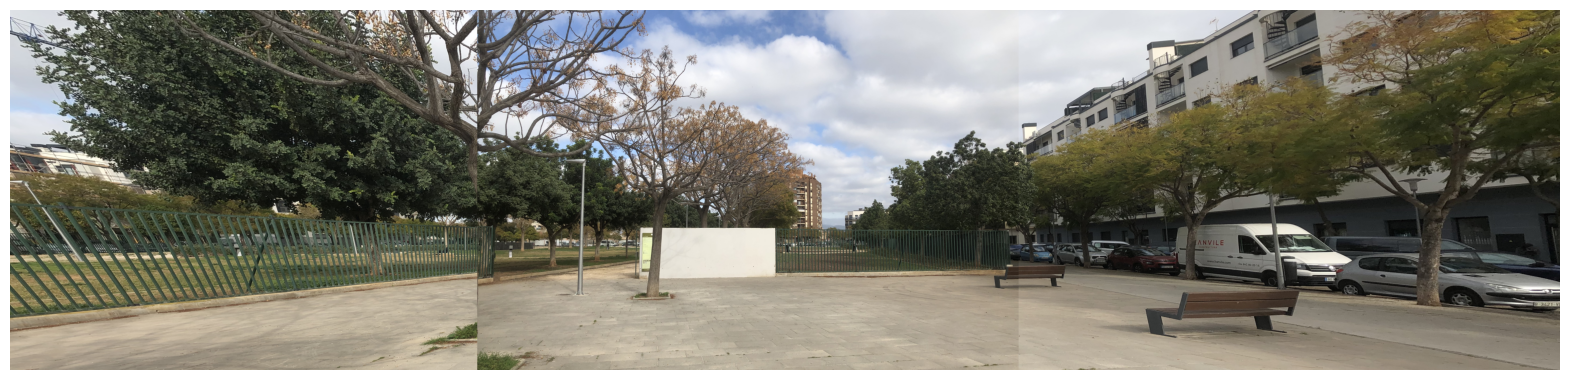

In [4]:
ratios = [0.5, 0.7, 0.9]
images = read_images('parque', extension='jpg', n=3)

for ratio in ratios:
    final = create_panoramic_view(images, match_ratio=ratio, verbose=False, crop=True)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.imshow(final);

We can see that in this case by increasing the matching ratio, we obtain a less accurate result, which can be observed in the alignment of the left and center images. This is because there are a lot of incorrect matches that are being considered when calculating the homography matrix.

### Keypoint detector experiments

In this section, experiments will be carried out to test the performance of the panoramic creation algorithm with different keypoint detectors. In particular, with the two that the algorithm can handle: SIFT and ORB, which are the most commonly used. We will use the default value for the matching ratio, which is 0.65. 

First of all, we can see that with both detectors a good result can be obtained, although it seems to be more accurate with SIFT in some details. For example, in this case the roof of the building on the left aligns better with SIFT than with ORB.

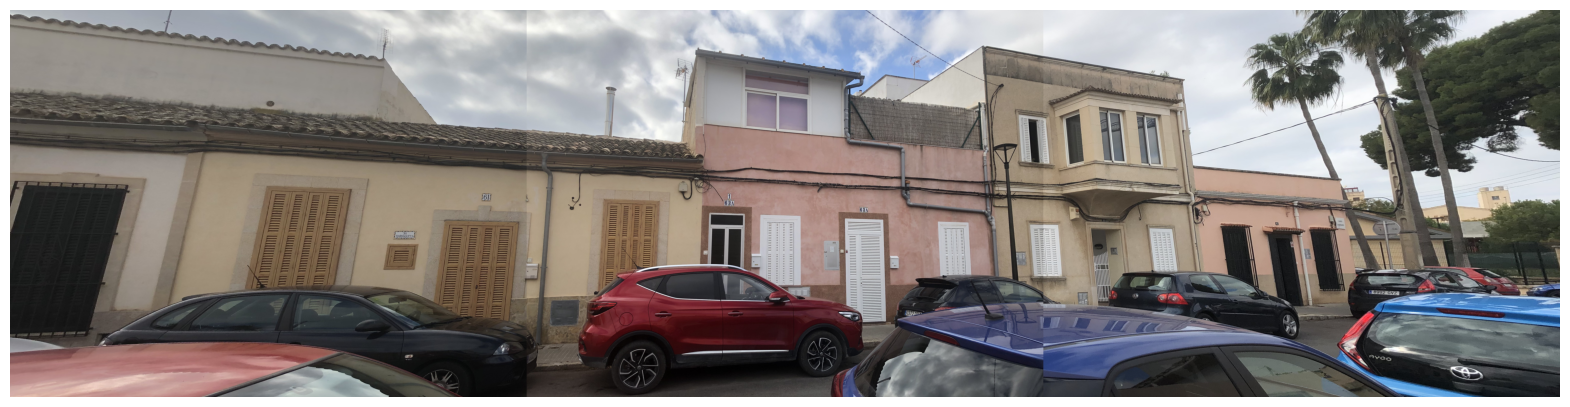

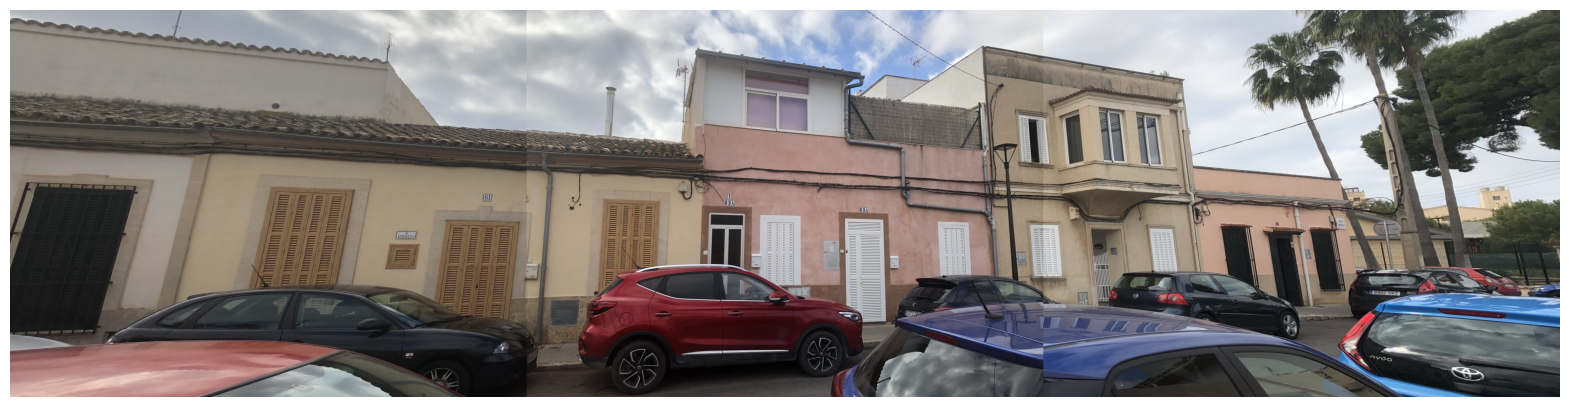

In [5]:
detectors = ['SIFT', 'ORB']
images = read_images('casas', extension='jpg', n=3)

for detector in detectors:
    final = create_panoramic_view(images, verbose=False, crop=False, detector=detector)
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle = detector
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.imshow(final);

These differences in accuracy come at a cost in execution time, as SIFT is significantly slower than ORB. Let's measure the execution time of both detectors to see if the difference is significant.

In [6]:
detectors = ['SIFT', 'ORB']
images = read_images('casas', extension='jpg', n=3)

times = {}
repeat = 5
for detector in detectors:
    time = timeit(lambda: create_panoramic_view(images, verbose=False, crop=False, detector=detector), number=repeat)
    times[detector] = time / repeat

In [7]:
df_times = pd.DataFrame(times, index=['Average Time (s)'])

# print(df_times.to_latex(float_format="%.2f", escape=False, caption="Execution times for different detectors.", label="tab:execution_times", index=True, bold_rows=True))
df_times

SIFT       ORB
Average Time (s)  19.911785  5.022414

We can see that the execution time of SIFT is much longer than that of ORB, so if speed is an important factor, it is better to use ORB, since the difference in the quality of the results is not significant.

### Crop experiments

When creating panoramas, you sometimes get images with black sections around the image. This is due to the fact that when calculating the homography, you obtain points that are outside the image. To solve this, a crop can be applied to the resulting image, eliminating the black sections. The difference between applying a crop and not applying a crop is shown below for an example where these edges are very evident.

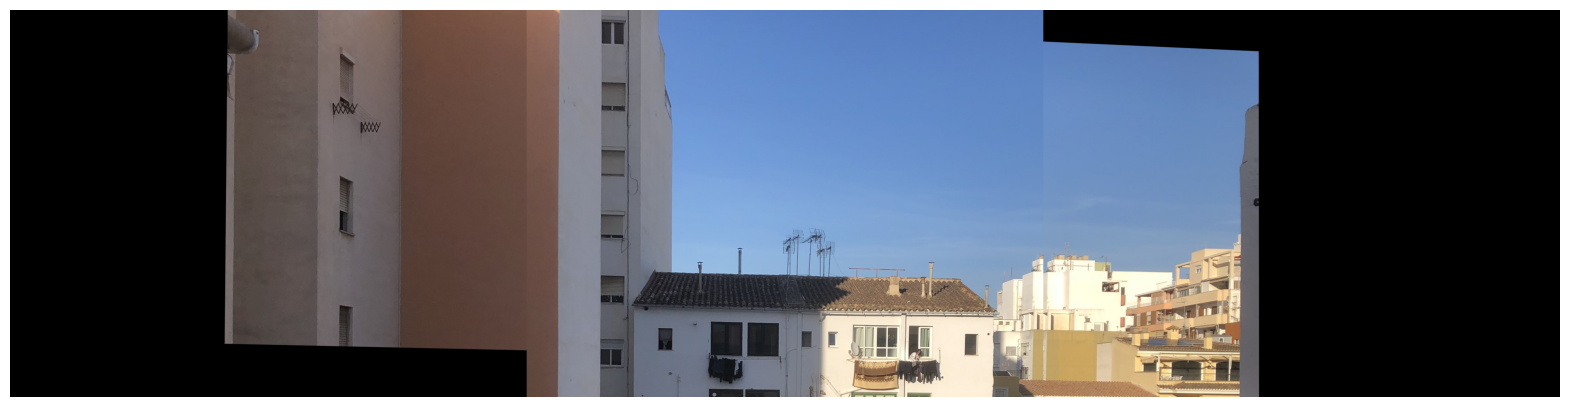

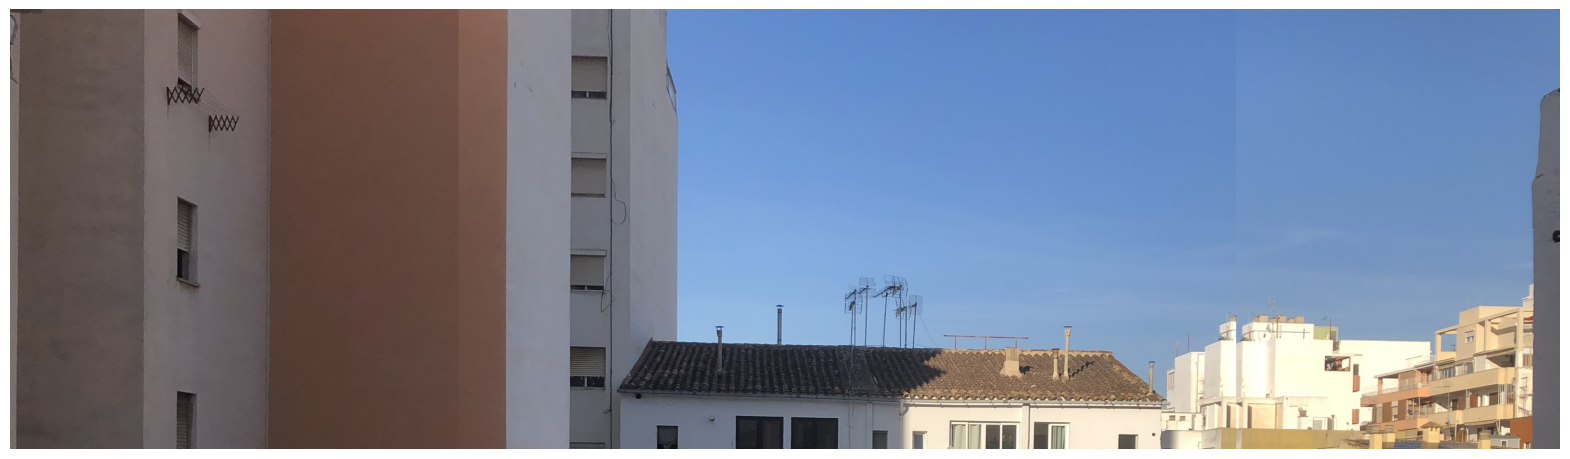

In [8]:
images = read_images('terraza', extension='jpg', n=3)

# WIHTOUT CROP
final = create_panoramic_view(images, match_ratio=ratio, verbose=False, crop=False)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(final);

# WITH CROP
final = create_panoramic_view(images, match_ratio=ratio, verbose=False, crop=True)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(final);


The second image corresponds to the largest rectangle that can be drawn inside the image without introducing black borders.